In [28]:
from PIL import Image
from pipeline import pipeline, segmentation_filter, user_palette_classification_filter, retrieval_filter
from utils import segmentation_labels, utils
from models import dataset, config
from sklearn.model_selection import train_test_split
import random
import torchvision.transforms as T
import matplotlib.pyplot as plt
from palette_classification import color_processing, palette
import glob
import json

In [29]:
# setting paths
palettes_path = 'palette_classification/palettes/'
cloth_dataset_path = 'dresscode_test_dataset/'
palette_mappings_path = 'palette_classification/clothing_palette_mappings/'

# loading reference palettes for user palette classification filter
palette_filenames = glob.glob(palettes_path + '*.csv')
reference_palettes = [palette.PaletteRGB().load(
    palette_filename.replace('\\', '/'), header=True) for palette_filename in palette_filenames]

# loading palette mappings for retrieval filter
palette_mappings_dict = {}
for category in ['dresses', 'lower_body', 'upper_body']:
    mapping_dict_filename = palette_mappings_path + category + '/' + category + '_palette_mappings.json'
    with open(mapping_dict_filename) as mapping_dict_file:
        palette_mappings_dict[category] = json.load(mapping_dict_file)

# instantiating pipeline
device = 'cuda'
pl = pipeline.Pipeline()

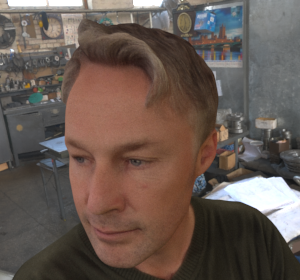

In [30]:
# loading random image from headsegmentation test dataset as pipeline input
n_classes = len(segmentation_labels.labels)
dataset_path = config.DATASET_PATH
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
_, X_test, _, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
rnd = False
i_ref = 2056
i = random.randint(0, len(X_test) - 1) if rnd is True else i_ref
input = Image.open(X_test[i]).convert('RGB')
input

In [31]:
# adding segmentation filter
segmentation_model = 'cloud' # should be in ['local', 'cloud']
sf = segmentation_filter.SegmentationFilter(segmentation_model)
pl.add_filter(sf)

In [32]:
# executing pipeline: sf
img, masks = pl.execute(input, device)
img_segmented = color_processing.colorize_segmentation_masks(masks, segmentation_labels.labels)

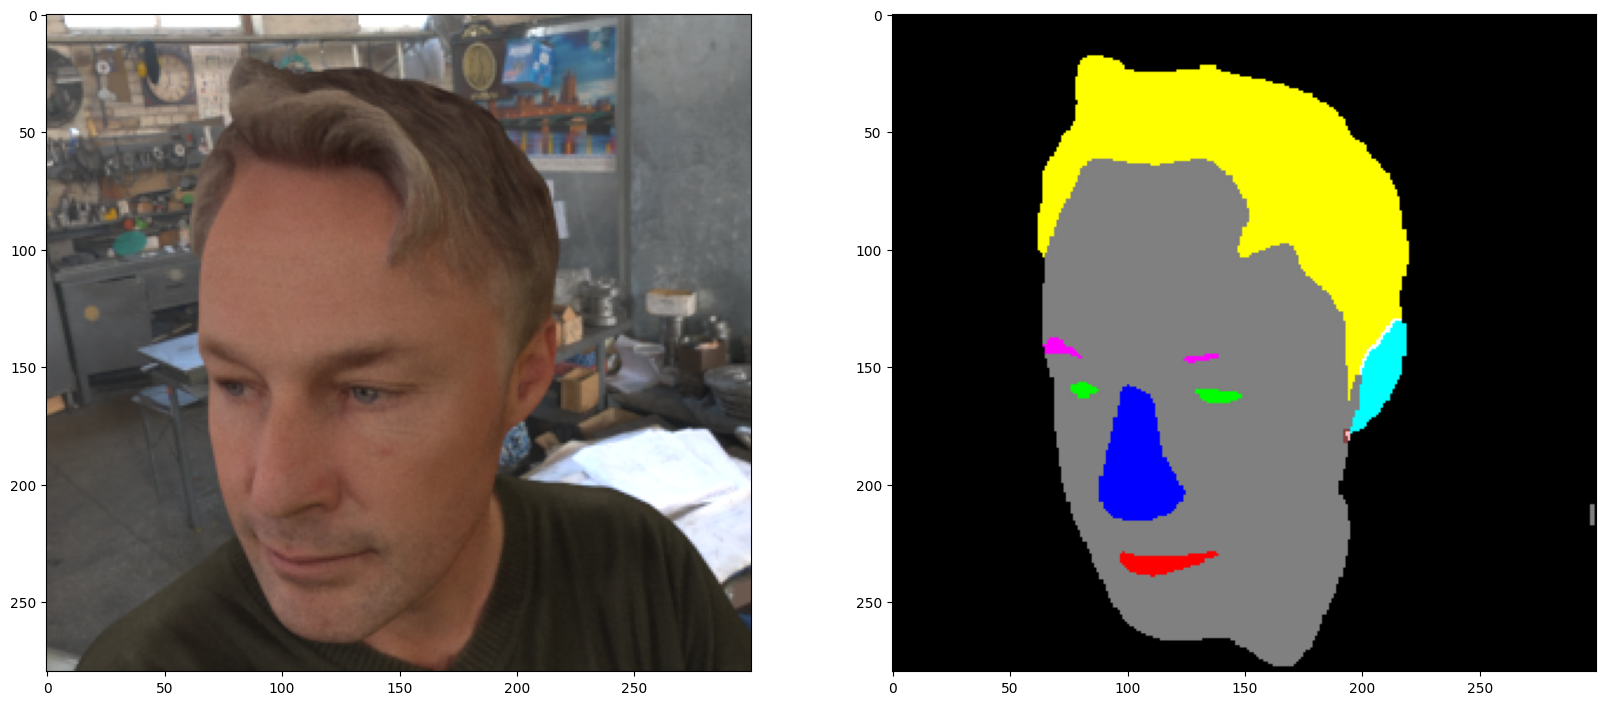

In [33]:
# showing output of pipeline: sf
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.imshow(utils.from_DHW_to_HWD(img))
plt.subplot(1, 2, 2)
plt.imshow(utils.from_DHW_to_HWD(img_segmented))

In [34]:
# adding user palette classification filter
upcf = user_palette_classification_filter.UserPaletteClassificationFilter(reference_palettes)
pl.add_filter(upcf)

In [35]:
# executing pipeline: sf -> upcf
user_palette = pl.execute(input, device)

spring


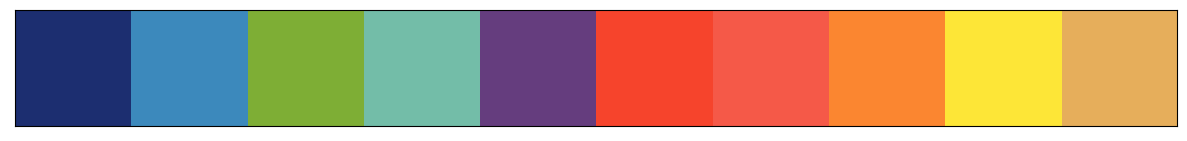

In [36]:
# # showing output of pipeline: sf -> upcf
print(user_palette.description())
user_palette.plot(tile_size=15)

In [37]:
# adding retrieval filter
query = 'upper_body' # should be in ['dress', 'upper_body', 'lower_body']
rf = retrieval_filter.RetrievalFilter(cloth_dataset_path, palette_mappings_dict)
rf.set_query(query)
pl.add_filter(rf)

In [38]:
# executing pipeline: sf -> upcf -> rf
retrieved_clothes_paths = pl.execute(input, device)
n_retrieved_clothes = len(retrieved_clothes_paths)
print(f'Found {n_retrieved_clothes} clothes for query "{query}" and palette "{user_palette.description()}".')

100%|██████████| 169/169 [01:38<00:00,  1.71it/s]


Found 1587 clothes for query "upper_body" and palette "spring".


Showing first 50 retrieved clothes.


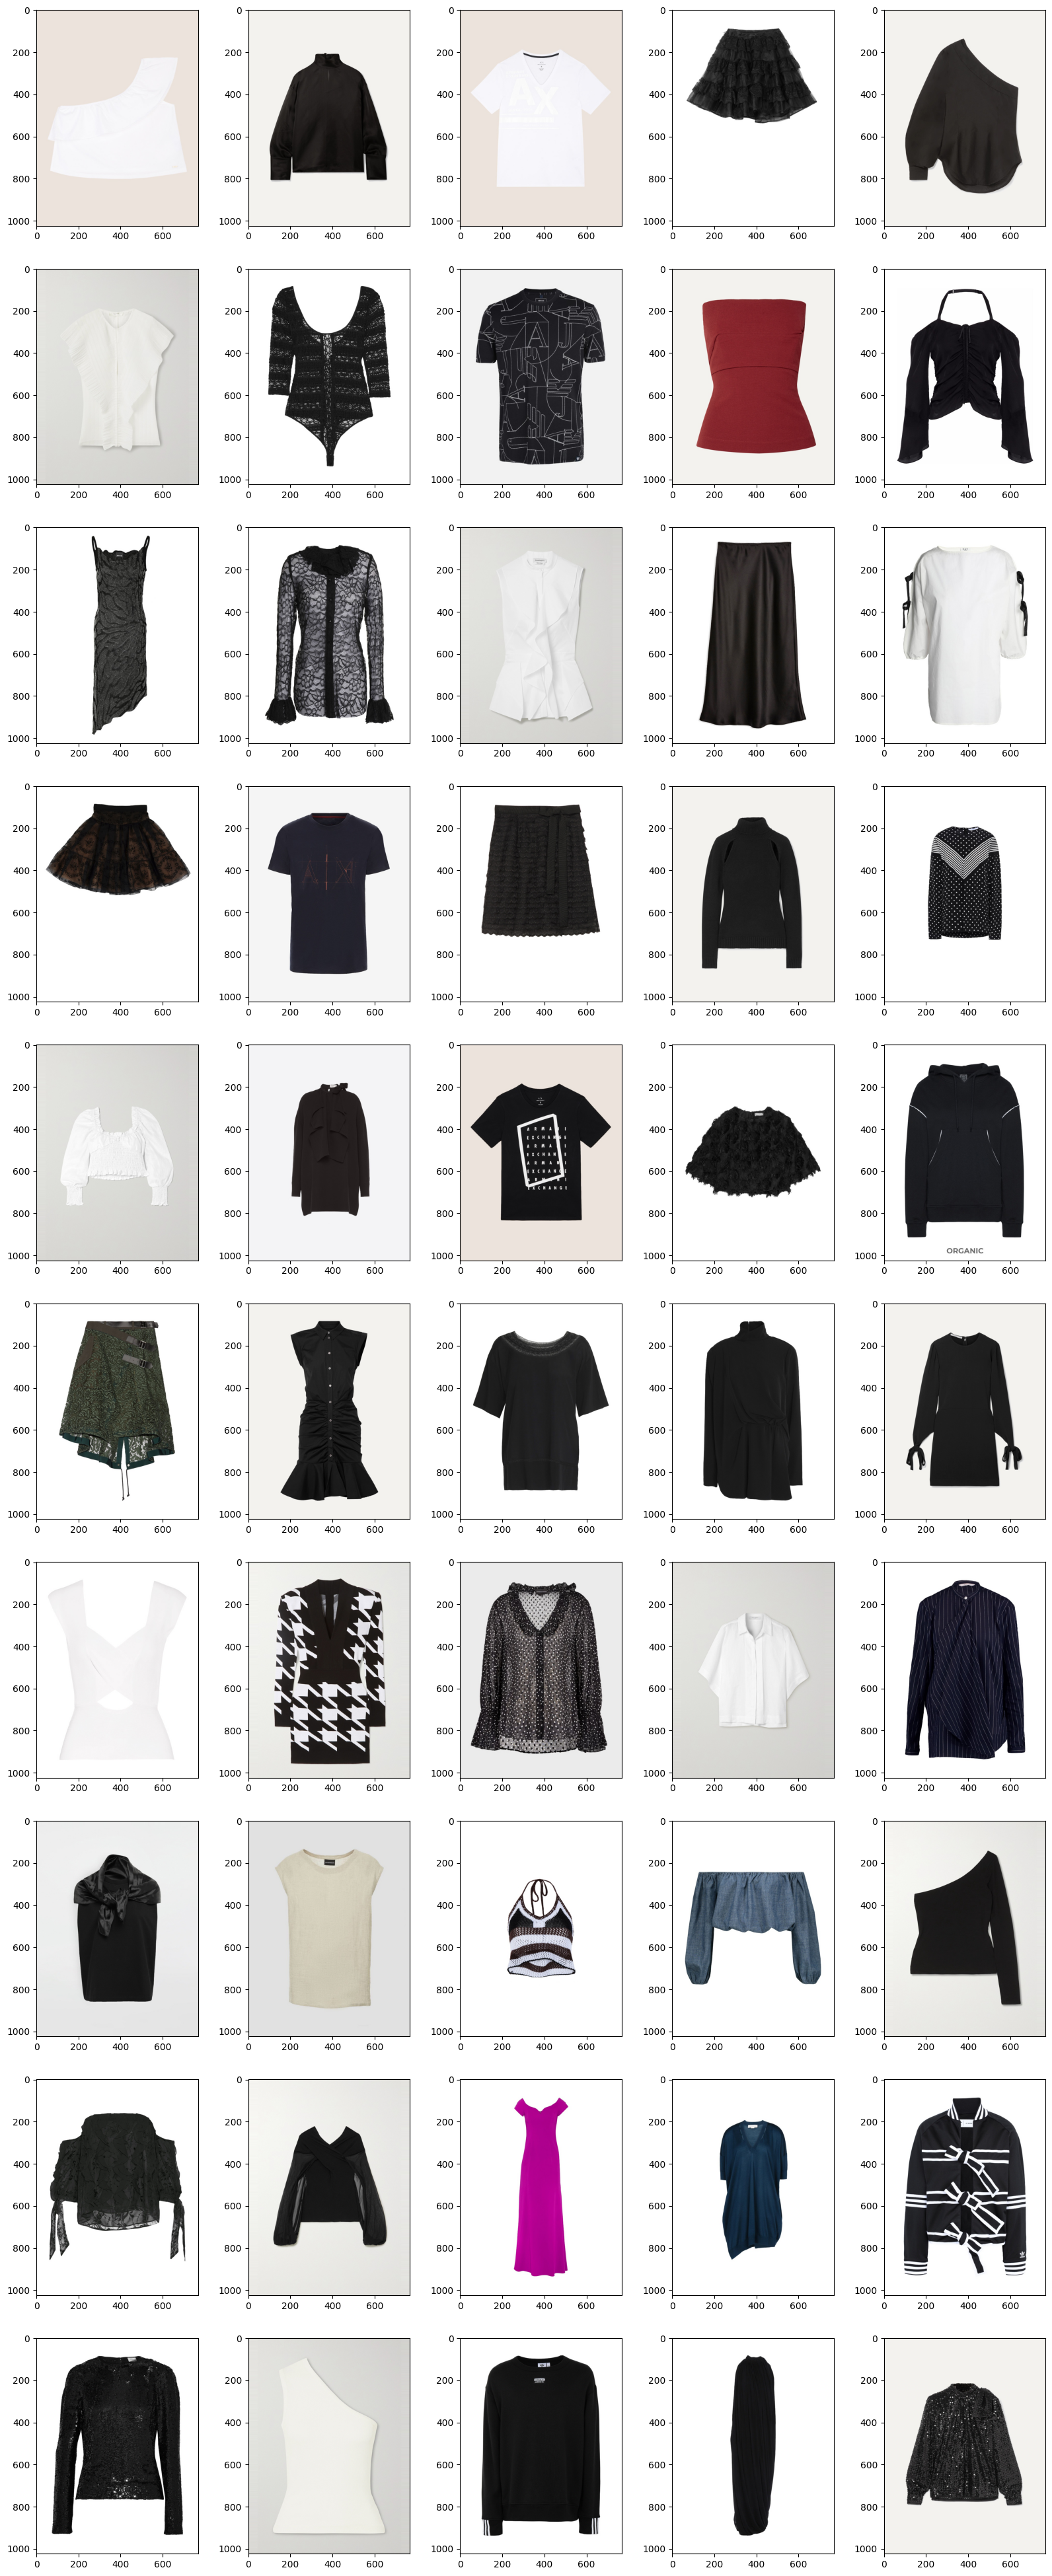

In [39]:
# === showing output of pipeline: sf -> upcf -> rf === 

n_results = 50

# plotting first n_results retrieved clothing items
i = 1
n_columns = min(n_results, 5)
n_rows = n_results // n_columns
print(f'Showing first {n_results} retrieved clothes.')
plt.figure(figsize=(20, 5 * n_rows))
for c in range(1, n_columns + 1):
    for r in range(1, n_rows + 1):
        plt.subplot(n_rows, n_columns, i)
        img = Image.open(retrieved_clothes_paths[i-1]).convert('RGB')
        plt.imshow(img)
        i += 1